# One Compartment Pharmacokinetics

**Pharmacokinetics** is a branch of pharmacology that studies the fate of chemical species in living organisms. The diverse range of applications includes administration of drugs and anesthesia in humans. This notebook describes a one compartment model for pharmacokinetics, and shows how the model can be used to determine strategies for the intravenous administration of an antimicrobial drug.

## Learning Goals

The notebook demonstrates use of a single, linear, first-order differential equation in the general form

$$\frac{dx}{dt} = a x + b u$$

to describe the dynamic response of a one-compartment model for a pharmacokinetics. The state is the concentration of an antimicrobrial in blood plasma. The input is a rate of intraveneous administration. The demonstrated analysis and simulation coding techniques can be used in a wide range of process applications.

## Antimicrobials

Antimicrobials are compounds that kill or slow the spread of micro-organisms. A large class of antimicrobials is used for disinfecting or sanitizing surfaces external to the body. Here we are considering antimicrobials that can be administered intravenously to treat bacterial infections. Examples include cephalosporins, flouroquinolones, penicillin, and others.

Let's consider the administration of an antimicrobial to a patient. Let $C(t)$ refers to the concentration of the antibiotic in blood plasma in units of [mg/L or $\mu$g/mL]. There are two concentration levels of interest in the medical use of an antimicrobial:

* **Minimum Inhibitory Concentration (MIC)** The minimum concentration of the antibiotic that prevents visible growth of a particular microorganism after overnight incubation. This enough to prevent further growth but may not be enought to "kill" the microorganism. ![](https://upload.wikimedia.org/wikipedia/commons/a/a2/Minimum_Inhibitory_Concentration.jpg)
<br> Image Source: Jenay DeCaussin, CC BY-SA 4.0 <https://creativecommons.org/licenses/by-sa/4.0>, via Wikimedia Commons

* **Minimum Bactricidal Concentration (MBC)** The lowest concentration of the antimicrobrial that prevents the growth of the microorganism after subculture to antimicrobrial-free media. MBC is generally the concentration needed "kill" the microorganism.

To treat an infection, it is necessary to achieve $C(t) \geq \text{MBC}$ for a sufficiently long period of time.  Extended exposure to an antimicrobrial at levels below MBC leads to [antimicrobrial resistance](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4378521/). 


## Why Model?

In research and development, a **mathematical model forms a testable hypothesis** of one's understanding of a system. The model can guide the design of experiments to validate or falsify the assumptions incorporated in the model.  

In the context of control systems, a **model can answer operating questions**. In pharmacokinetic applications, the operational questions include:

* How do we find values for the model parameters?
* How long will it take to clear the antimicrobial from the body?
* What rate of antimicrobial addition is required to achieve the minimum bactricidal concentration?
* If doses are administered periodically, how large should each dose be, and how frequently should the doses be administered?

Questions like these can be answered through regression to experimental data, simulation, and analysis. We'll explore several of these techniques below.

1. Steady state analysis
1. Typical simulations
    * How does a system respond following an initial condition on the state?
    * How does the system respond to time-varying inputs?
    * When do important events occur?
1. Alternative model formulations
    * State space model
    * Gain and time constant model

## One-Compartment Pharmacokinetic Model

A one-compartment pharmacokinetic model assumes the antimicrobial is distributed in a single compartment of the body with constant plasma volume $V$. The plasma blood volume $V$ can be estimated as follows. First estimate the total blood volume (TBV) in liters where

$$
\begin{align*}
\text{TBV} = v \times W
\end{align*}
$$

where $W$ is the patient's weight in kg, and v = 0.065 liters for females, v = 0.070 liters for males. Then

$$
\begin{align*}
V =  \text{TBV}\times (1 - \text{Hct})
\end{align*}
$$

where $\text{Hct}$ is the patient's measured hematocrit, which is the volume fraction of blood that is comprised of red blood cells. Typical hematocrit levels are 36% to 48% for females, 41% to 50% for males. 

The plasma is assumed to be sufficiently well mixed that the drug is uniformly distributed with concentration $C(t)$. The drug enters the plasma by injection at rate $u(t)$ meaasured in mg/hour or similar units. The drug leaves the body as a component of the plasma where $Q$ is the constant plasma clearance rate.

![](./figures/PK-one-compartment.png)

A generic mass balance for a single species is given by

$$\fbox{Rate of Accumulation} = \fbox{Inflow} - \fbox{Outflow} + \fbox{Production by reaction} - \fbox{Consumption by reaction}$$

Assuming the drug is neither produced or consumed by reaction in the body, this generic mass balance can be translated to differential equation

$$\begin{align*}
\underbrace{\fbox{Rate of Accumulation}}_{V \frac{dC}{dt}} & = \underbrace{\fbox{Inflow}}_{u(t)} - \underbrace{\fbox{Outflow}}_{Q C(t)} + \underbrace{\fbox{Production by reaction}}_0 - \underbrace{\fbox{Consumption by reaction}}_0
\end{align*}$$

Summarizing,

$$V \frac{dC}{dt} = u(t) - Q C(t)$$

This model is characterized by two parameters, the plasma volume $V$ and the clearance rate $Q$.

## A Sample Problem Statement 

Assume the minimum inhibitory concentration (MIC) of a microorganism to a antimicrobial is 5 mg/liter, and the minimum bactricidal concentration (MBC) is 8 mg/liter. Assume the plasma volume $V$ is 4 liters with a clearance rate $Q$ of 0.5 liters/hour. 

An initial intravenous antimicrobial dose of 64 mg in a plasma volume of 4 liters gives an initial plasma concentration $C_{initial}$ of 16 mg/liter.  

* How long will the concentration $C(t)$ stay above MBC?  
* How long with will $C(t)$ stay above MIC?

## Simulation from a Known Initial Condition

### Solution Strategy

The questions raised in the problem statement can be answered through simulation. Given the model parameters in the problem statement, the task is to simulate the response and determine when certain events are encountered.

We could solve this two different ways:

1. Analytical solution. This is a linear first-order differential equation with constant coefficients with a known analytical solution. The questions above can be answered from the closed-form solution.

2. Numerical solution. The are many computational alternatives for solving systems of one or more differential equations. In this case there is the extra consideration of finding when certain events take place. As will be shown below, [integrate.solve_ivp](https://docs.scipy.org/doc/scipy/reference/generated/scipy.integrate.solve_ivp.html) from the [SciPy](https://scipy.org/) library is well suited to these tasks.

Below we will develop a numerical solution step-by-step, then consolidate these steps into a single cell that can be extended to more complex applications.

### Step 1. Import libraries

For this first simulation we compute the response of the one compartment model due starting with an initial condition $C_{initial}$, and assuming input $u(t) = 0$. We will use the [`solve_ivp`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.integrate.solve_ivp.html) function for solving differential equations from the `scipy.integrate` library. We will save plots to subdirectories for later reference.

The first steps to a solution are:

1. Import the `numpy` library for basic mathematical functions.
2. Import the `matplotlib.pyplot` library for plotting.
3. Import ``solve_ivp` from the `scipy.integraate` library
4. Import `os` for functions needed to save plots to subdirectories.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
import os

### Step 2. Enter Parameter Values

In [2]:
V = 4           # liters
Q = 0.5         # liters/hour
MIC = 5         # mg/liter
MBC = 8         # mg/liter

C_initial = 16  # mg/liter

### Step 3. Write the differential equation in standard form

The most commonly used solvers for systems of differential equations require a function evaluating the right hand sides of the differential equations when written in a standard form

$$\frac{dC}{dt} = \frac{1}{V}u(t) - \frac{Q}{V}C$$

Here we write this as a composition of two functions. The first function returns values of the input $u(t)$ for a specified point in time. The second returns values of the right hand side as a function of time and state.

In [3]:
def u(t):
    return 0

def deriv(t, C):
    return u(t)/V - (Q/V)*C

### Step 4. Solution

The problem statement seeks information about specific events. The Python function [scipy.integrate.solve_ivp](https://docs.scipy.org/doc/scipy/reference/generated/scipy.integrate.solve_ivp.html) provides a means of tracking events, such as the crossing a value treshhold. Here we will use this capability to find precise answers to when the concentration falls below the MBC and MIC levels.

In [4]:
# specify time span and evaluation points
t_span = [0, 24]
t_eval = np.linspace(0, 24)

# initial conditions
IC = [C_initial]

# compute solution
soln = solve_ivp(deriv, t_span, IC, t_eval=t_eval)

# display solution
print(soln)

  message: 'The solver successfully reached the end of the integration interval.'
     nfev: 38
     njev: 0
      nlu: 0
      sol: None
   status: 0
  success: True
        t: array([ 0.        ,  0.48979592,  0.97959184,  1.46938776,  1.95918367,
        2.44897959,  2.93877551,  3.42857143,  3.91836735,  4.40816327,
        4.89795918,  5.3877551 ,  5.87755102,  6.36734694,  6.85714286,
        7.34693878,  7.83673469,  8.32653061,  8.81632653,  9.30612245,
        9.79591837, 10.28571429, 10.7755102 , 11.26530612, 11.75510204,
       12.24489796, 12.73469388, 13.2244898 , 13.71428571, 14.20408163,
       14.69387755, 15.18367347, 15.67346939, 16.16326531, 16.65306122,
       17.14285714, 17.63265306, 18.12244898, 18.6122449 , 19.10204082,
       19.59183673, 20.08163265, 20.57142857, 21.06122449, 21.55102041,
       22.04081633, 22.53061224, 23.02040816, 23.51020408, 24.        ])
 t_events: None
        y: array([[16.        , 15.049792  , 14.15601545, 13.31532006, 12.5243503 ,
 

### Step 5. Visualization

We wish to determine when the plasma concentration $C(t)$ falls below the MIC and MBC thresholds. We can get an estimate by examing a plot of these concentrations as a function of time. The following code cell presents a function to create a plot from the `soln` object ajd saves the plot to a file for later comparison.

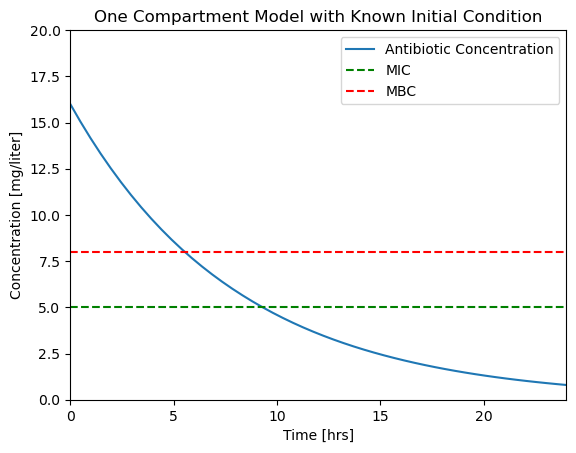

In [5]:
def plotConcentration(soln):
    fig, ax = plt.subplots(1, 1)
    ax.plot(soln.t, soln.y[0])
    ax.set_xlim(0, max(soln.t))
    ax.plot(ax.get_xlim(), [MIC, MIC], 'g--', ax.get_xlim(), [MBC, MBC], 'r--')
    ax.set_ylim(0, 20)
    ax.legend(['Antibiotic Concentration','MIC','MBC'])
    ax.set_xlabel('Time [hrs]')
    ax.set_ylabel('Concentration [mg/liter]')
    ax.set_title('One Compartment Model with Known Initial Condition');
    return ax
    
plotConcentration(soln)

# save solution to a file for reuse in documents and reports
os.makedirs("figures", exist_ok=True)
plt.savefig('./figures/Pharmaockinetics1.png')

## Finding Events in a Simulation

At this point we have a complete simulation. But we  don't yet have a numerical answer to the question of when the concentration of the antimicrobial in the blood plasma falls below the MIC and MBC threshold values.

Locating events is a common task for simulation studies. Events might include

* a variable falling below a threshold value,
* a variable increasing above a threshold value,
* a variable crossing a threshold value, regardless of direction,
* reaching a local maximum or minimum value,
* crossing an upper alarm threshold in a positive going direction,
* crossing a lower alarm threshold in a negative going direction,
* a simulation of two objects coming into contact.

An **event** refers to conditions on the state of a system that may be satisfied at discrete points in time. More than one event can be specified for a system. The simulation task is compute and report the time at which the specified events occur, and possibly to interrupt the simulation to take some action.

The problem statement for the pharamcokinetics describeds two events of interest:

* An event that occurs when the value of $C(t)$ is equal to threshold value of MBC and falling. We will call this event `cross_mcb`.
* An event we will call `cross_mic` occurs when the value of $C(t)$ is equal to threshold value MIC and falling. The simulation is finished when this event occurs.

`solve_ivp` provides a [technique for specifying events](https://docs.scipy.org/doc/scipy/reference/generated/scipy.integrate.solve_ivp.html). Events are specified in two steps. First a Python `def` command defines a function that returns a value of zero when variables take the value corresponding to the event. Next, additional properties are assigned to function to add further specifications to the event.

The `cross_mbc` event occurs when (1) the value of $C(t)$ is equal to MBC and (2) crossing the MBC threshold in a negative going direction. Here's how to translate these conditions into Python code for use by `solve_ivp`.

In [6]:
def cross_mbc(t, y):
    """Return zero when y[0] is equal to MBC."""
    return y[0] - MBC

# specify the event occurs when the value of cross_mbc is in a negative going direction
cross_mbc.direction = -1

The `cross_mic` event is defined analogously to `cross_mbc`, but with an additional specification that terminates the simulation when the event occurs.

In [7]:
def cross_mic(t, y):
    """Return zero when y[0] is equal to MIC."""
    return y[0] - MIC

cross_mic.direction = -1
cross_mic.terminal = True

The simulation is created by packing all of the event objects into a list and passing that list to `solve_ivp` as an argument named `events`. 

In [8]:
# specify time span and evaluation points
t_span = [0, 24]
t_eval = np.linspace(0, 24)

# initial conditions
IC = [C_initial]

# specify a list of events
events = [cross_mbc, cross_mic]

# compute solution
soln = solve_ivp(deriv, t_span, IC, events=events, t_eval=t_eval)

# display solution
print(soln)

  message: 'A termination event occurred.'
     nfev: 26
     njev: 0
      nlu: 0
      sol: None
   status: 1
  success: True
        t: array([0.        , 0.48979592, 0.97959184, 1.46938776, 1.95918367,
       2.44897959, 2.93877551, 3.42857143, 3.91836735, 4.40816327,
       4.89795918, 5.3877551 , 5.87755102, 6.36734694, 6.85714286,
       7.34693878, 7.83673469, 8.32653061, 8.81632653, 9.30612245])
 t_events: [array([5.53942584]), array([9.31072423])]
        y: array([[16.        , 15.049792  , 14.15601545, 13.31532006, 12.5243503 ,
        11.779541  , 11.07848539, 10.41894155,  9.79872358,  9.21570167,
         8.66780203,  8.15300696,  7.6693548 ,  7.21493994,  6.78791284,
         6.38648   ,  6.00890398,  5.65350342,  5.31865298,  5.00287861]])
 y_events: [array([[8.]]), array([[5.]])]


The solution object now constaints lists named `t_events` and `y_events`. Each list contains one array for each event object. Each of those arrays contain the time and values of every occurance of the corresponding event object. 

Text([9.31072423], [[6.]], 't = 9.31')

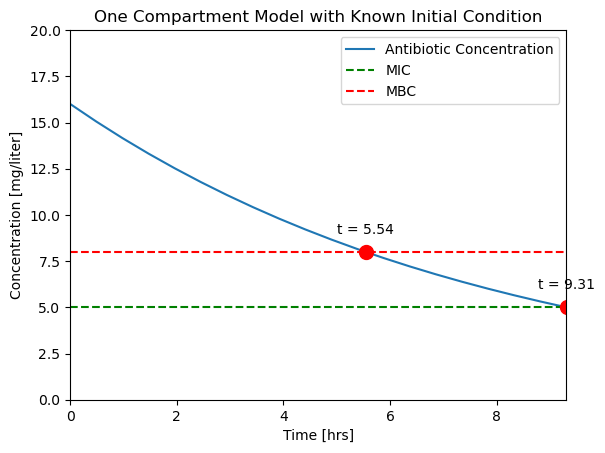

In [9]:
ax = plotConcentration(soln)

t_mbc = soln.t_events[0]
C_mbc = soln.y_events[0]
ax.plot(t_mbc, C_mbc, 'r.', ms=20)
ax.text(t_mbc, C_mbc + 1, f"t = {t_mbc[0]:.2f}", ha="center")

t_mic = soln.t_events[1]
C_mic = soln.y_events[1]
ax.plot(t_mic, C_mic, 'r.', ms=20)
ax.text(t_mic, C_mic + 1, f"t = {t_mic[0]:.2f}", ha="center")

## Simulation using a Time-Dependent Input

Let's compare the results we saved earlier to a typical experimental result {cite}`Levison:2009ww`.

| | |
| :-: | :-: |
|![](./figures/Pharmaockinetics1.png)|![](figures/nihms-475924-f0001.jpg)|

We see that that the assumption of a fixed initial condition is questionable. Can we fix this?

For the next simulation we will assume the dosing takes place over a short period of time $\delta t$. To obtain a total dose $U_{dose}$ in a time period $\delta t$, the mass flow rate rate must be

$$u(t) = 
\begin{cases}
U/ \delta t \qquad \mbox{for } 0 \leq t \leq \delta t \\
0 \qquad \mbox{for } t \geq \delta t
\end{cases}
$$

To match results with the prior calculations, we note  a total dose of $U_{dose} = V \times C(0)$ = 64 mg will be injected at a rate $U_{dose}/dt$ over the specified time period $dt$.

Before doing a simulation, we will write a Python function for $u(t)$. 

In [10]:
# parameter values
dt = 1.5         # length hours
Udose = 64       # mg

# function defintion
def u(t):
    if t <= 0:
        return 0
    elif t <= dt:
        return Udose/dt
    else:
        return 0

This code cell demonstrates the use of a list comprehension to apply a function to each value in a list.

Text(0.5, 1.0, 'Dosing function u(t) for of total dose 64 mg')

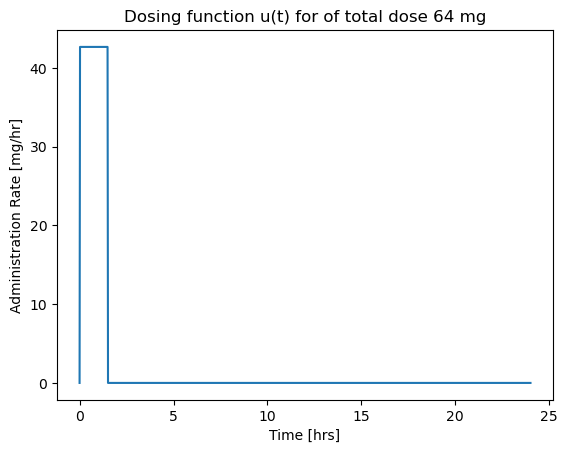

In [11]:
# visualization
t = np.linspace(0, 24, 1000)              # create a list of time steps

fig, ax = plt.subplots(1, 1)
ax.plot(t, [u(tau) for tau in t])
ax.set_xlabel('Time [hrs]')
ax.set_ylabel('Administration Rate [mg/hr]')
ax.set_title('Dosing function u(t) for of total dose {0} mg'.format(Udose))

For this simulation we add both `cross_mbc` and `cross_mic` events, but without specifying termination.

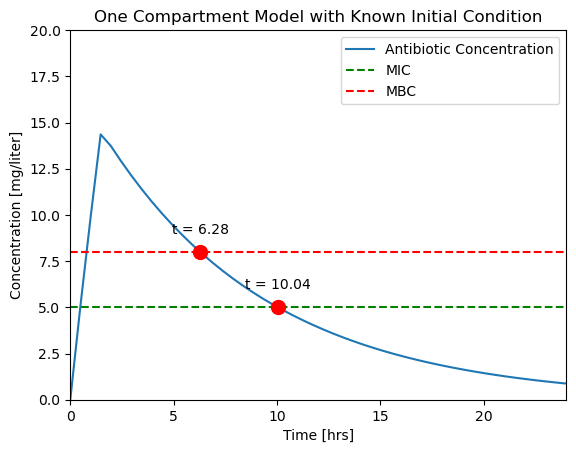

In [12]:
# specify time span and evaluation points
t_span = [0, 24]
t_eval = np.linspace(0, 24, 50)

# initial conditions
C_initial = 0
IC = [C_initial]

# events
def cross_mbc(t, y):
    return y[0] - MBC
cross_mbc.direction = -1

def cross_mic(t, y):
    return y[0] - MIC
cross_mic.direction = -1

events = [cross_mbc, cross_mic]

# compute solution
soln = solve_ivp(deriv, t_span, IC, events=events, t_eval=t_eval)

# display solution
ax = plotConcentration(soln)

t_mbc = soln.t_events[0]
C_mbc = soln.y_events[0]
ax.plot(t_mbc, C_mbc, 'r.', ms=20)
ax.text(t_mbc, C_mbc + 1, f"t = {t_mbc[0]:.2f}", ha="center")

t_mic = soln.t_events[1]
C_mic = soln.y_events[1]
ax.plot(t_mic, C_mic, 'r.', ms=20)
ax.text(t_mic, C_mic + 1, f"t = {t_mic[0]:.2f}", ha="center")

os.makedirs("figures", exist_ok=True)
plt.savefig('./figures/Pharmaockinetics2.png')

Let's compare our results to a [typical experimental result](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3675903/pdf/nihms-475924.pdf) {cite}`Levison:2009ww`.

| | |
| :-: | :-: |
|![](./figures/Pharmaockinetics2.png)|![](./figures/nihms-475924-f0001.jpg)|

While it isn't perfect, this is a closer facsimile of actual physiological response.

## Periodic Dosing

### Problem Statement

The minimum inhibitory concentration (MIC) of a particular organism to an antibiotic is 5 mg/liter, the minimum bactricidal concentration (MBC) is 8 mg/liter. Assume the plasma volume $V$ is 4 liters with a clearance rate $Q$ of 0.5 liters/hour. 

Design an antibiotic therapy to keep the plasma concentration above the MIC level for a period of 96 hours. 

### Solution

We consider the case of repetitive dosing where a new dose is administered every $t_{dose}$ hours. A simple Python "trick" for this calculation is the `%` operator which returns the remainder following division. This is a useful tool whenever you need to functions that repeat in time.

In [13]:
# parameter values
dt = 2           # length of administration for a single dose
tdose = 8        # time between doses
Udose = 42       # mg

# function defintion 
def u(t):
    return Udose/dt if t % tdose <= dt else 0

Text(0.5, 1.0, 'Dosing function u(t) for of total dose 42 mg')

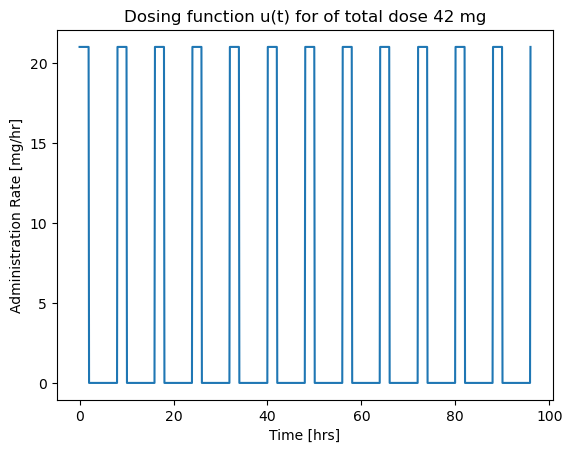

In [14]:
# visualization
t = np.linspace(0, 96, 1000)              # create a list of time steps

fig, ax = plt.subplots(1, 1)
ax.plot(t, [u(tau) for tau in t])
ax.set_xlabel('Time [hrs]')
ax.set_ylabel('Administration Rate [mg/hr]')
ax.set_title('Dosing function u(t) for of total dose {0} mg'.format(Udose))

The dosing function $u(t)$ is now applied to the simulation of drug concentration in the blood plasma. A fourth argument is added to `odeint(deriv, Cinitial, t, tcrit=t)` indicating that special care must be used for every time step. This is needed in order to get a high fidelity simulation that accounts for the rapidly varying values of $u(t)$.

None


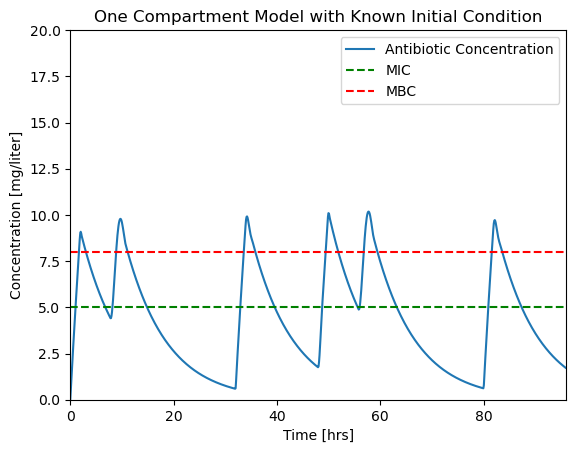

In [15]:
# specify time span and evaluation points
t_span = [0, 96]
t_eval = np.linspace(0, 96, 1000)

# initial conditions
C_initial = 0
IC = [C_initial]

# compute solution
soln = solve_ivp(deriv, t_span, IC, t_eval=t_eval)

# display solution
plotConcentration(soln)
os.makedirs("figures", exist_ok=True)
plt.savefig('./figures/Pharmaockinetics3.png')

print(soln.t_events)

This looks like a unevem. The problem here is that the solver is using time steps larger than the dosing interval and missing important changes in the input. 

The fix is to specify the `max_step` option for the solver. `max_step` sets the maximum step size for the solver. As a rule of thumb, your simulations should always specify a `max_step` shorter than the minimum feature in the input sequence. In this case we specify a `max_step` of 0.1 hr which is short enough to not miss detail in $u(t)$.

None


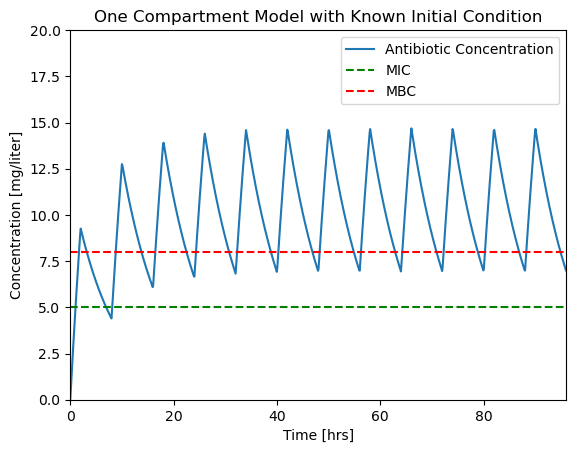

In [16]:
# specify time span and evaluation points
t_span = [0, 96]
t_eval = np.linspace(0, 96, 1000)

# initial conditions
C_initial = 0
IC = [C_initial]

# compute solution
soln = solve_ivp(deriv, t_span, IC, t_eval=t_eval, max_step=0.1)

# display solution
plotConcentration(soln)
os.makedirs("figures", exist_ok=True)
plt.savefig('./figures/Pharmaockinetics4.png')

print(soln.t_events)

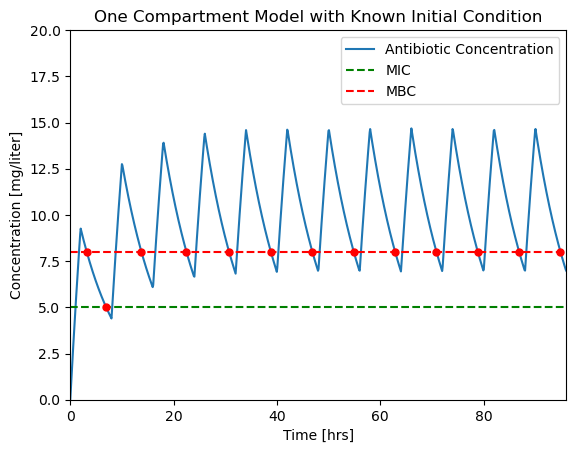

In [17]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
import os

# parameter values
V = 4           # liters
Q = 0.5         # liters/hour
MIC = 5         # mg/liter
MBC = 8         # mg/liter
C_initial = 0   # mg/liter

# differential equation
def deriv(t, C):
    return u(t)/V - (Q/V)*C

# input parameter values
dt = 2           # length of administration for a single dose
tdose = 8        # time between doses
Udose = 42       # mg
def u(t):
    return Udose/dt if t % tdose <= dt else 0

# events
def cross_mbc(t, y):
    return y[0] - MBC
cross_mbc.direction = -1

def cross_mic(t, y):
    return y[0] - MIC
cross_mic.direction = -1

events = [cross_mbc, cross_mic]

# specify time span and evaluation points
t_span = [0, 96]
t_eval = np.linspace(0, 96, 1000)

# initial conditions
C_initial = 0
IC = [C_initial]

# compute solution
soln = solve_ivp(deriv, t_span, IC, events=events, t_eval=t_eval, max_step=0.1)

# display solution
ax = plotConcentration(soln)
for j, event in enumerate(events):
    for k, t in enumerate(soln.t_events[j]):
        ax.plot(t, soln.y_events[j][k][0], 'r.', ms=10)
    
os.makedirs("figures", exist_ok=True)
plt.savefig('./figures/Pharmaockinetics5.png')